In [5]:
#Import packages
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer.pitch import Pitch, VerticalPitch
import seaborn as sns
import ipywidgets as widgets
from highlight_text import  ax_text, fig_text
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib as mpl

#read csv
df = pd.read_csv('Footballdata/Season/EPL.csv', encoding='latin-1')
df = df.fillna(0)

#Only obtaining actions happening below 60% of the pitch for team in question
df = df.loc[(df['endX']<60)]

#Remove corner kicks
df = df.loc[~(df['x']==99.5)]

#Adjust to pitch size
df['x'] = df['x']*1.2
df['y'] = df['y']*.8
df['endX'] = df['endX']*1.2
df['endY'] = df['endY']*.8

#remove substitution events,challenges & formation change
df = df.loc[~(df['type/displayName'] == 'SubstitutionOff')]
df = df.loc[~(df['type/displayName'] == 'SubstitutionOn')]
df = df.loc[~(df['type/displayName'] == 'FormationChange')]
df = df.loc[~(df['type/displayName'] == 'Challenge')]
df = df.loc[~(df['type/displayName'] == 'FormationSet')]
df = df.loc[~(df['type/displayName'] == 'Start')]
df = df.loc[~(df['type/displayName'] == 'End')]

C:\Users\user\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3266: DtypeWarning: Columns (30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


KeyError: 'type/displayName'

In [ ]:
#Kit Number
df['Kit Number'] = df['Kit Number'].astype(int)

#Make a new, single column for time and sort the events in chronological order
df["newsecond"] = 60*df["minute"]+df["second"]

df.sort_values(by=['newsecond'])

#find if the next event is by the same team
df['teamId_next'] = df['teamId'].shift(-1)

#finding the Recipient of the action/pass made
df['Recipient'] = df['playername'].shift(-1)

"""df = df.drop(['eventId', 'expandedMinute', 'period/value','type/value','outcomeType/value',
              'blockedX','blockedY','goalMouthZ','goalMouthY','isShot','isGoal'], axis=1)
"""
df['newsecond_next'] = df['newsecond'].shift(-1)
df['newseconddiff'] = df['newsecond_next'] - df['newsecond']

In [ ]:
#Passes that get dispossessed for holding it too long
df['Pass1'] = np.where((df['type/displayName'] == 'Pass') & (df['outcomeType/displayName'] == 'Successful') & 
                       (df['teamId'] == df['teamId_next']) & (df['type/displayName'].shift(-1) == 'Dispossessed') &
                       (df['type/displayName'].shift(-2) == 'Tackle') & 
                       (df['outcomeType/displayName'].shift(-2) == 'Successful') &
                       (df['type/displayName'].shift(-3) == 'BallRecovery') & (df['newseconddiff'] <= 5), 1,0)

#Passes that get block
df['Pass2'] = np.where((df['type/displayName'] == 'Pass') & (df['outcomeType/displayName'] == 'Successful') & 
                       (df['teamId'] == df['teamId_next']) & (df['type/displayName'].shift(-1) == 'Pass') &
                       (df['outcomeType/displayName'].shift(-1) == 'Unsuccessful') & 
                       (df['type/displayName'].shift(-2) == 'BlockedPass') & (df['newseconddiff'] <= 5), 1,0)


df1 = df.loc[(df['Pass1'] == 1) | (df['Pass2'] == 1)]

In [2]:
#List of Pass Attempts
PassAttempts = df.loc[(df['type/displayName']=='Pass')]
pass_list = PassAttempts.groupby(['playername','teamId']).size().reset_index().rename(columns={0:'Attempted Passes'}).sort_values('playername', ascending = True).reset_index()
del pass_list['index']

#List of Successful Passes
SuccessfulPass = df.loc[(df['type/displayName']=='Pass') & (df['outcomeType/displayName']=='Successful')]

#Filter to make sure recipients are from the same team
SuccessfulPass = SuccessfulPass.loc[(SuccessfulPass['teamId_next'] == SuccessfulPass['teamId'])]

successful_pass_list = SuccessfulPass.groupby(['playername','teamId']).size().reset_index().rename(columns={0:'Successful Passes'}).sort_values('playername', ascending = True).reset_index()
del successful_pass_list['index']

#Merge
#Merge the two lists
Passes = pd.merge(pass_list, successful_pass_list, on="playername")
Passes = Passes.drop(['teamId_y'], axis = 1)
Passes.rename(columns = {'teamId_x':'Team', 'playername':'Player'},inplace = True)
Passes['Pass Completion %'] =((Passes['Successful Passes'] / Passes['Attempted Passes'])*100).round(decimals = 2)
Passes = Passes.sort_values('Successful Passes', ascending= False).reset_index(drop = True)
Passes.index += 1
Passes

NameError: name 'df' is not defined

In [3]:
#Bad Passes
Passlist = df1.groupby(['playername']).size().reset_index().rename(columns={0:'Bad Passes'}).sort_values('playername', ascending = True).reset_index()
Passlist.rename(columns = {'teamId':'Team', 'playername':'Player'},inplace = True)
del Passlist['index']

#Merge
#Merge the two lists
Passes = pd.merge(Passes, Passlist, on="Player")
Passes = Passes.sort_values('Bad Passes', ascending= False).reset_index(drop = True)
Passes.index += 1
Passes.head(30)

NameError: name 'df1' is not defined

In [24]:
#Combo box, choose players
options = Passes["Team"].unique()
options = options.tolist()

options = [x for x in options if str(x) != 'nan']
teamlist = widgets.Combobox(
    placeholder='Enter a team',
    options=options,
    description='Team:',
    ensure_option=True,
    disabled=False
)
teamlist

Combobox(value='', description='Team:', ensure_option=True, options=('Newcastle United', 'Bournemouth', 'Manch…

In [17]:
team = teamlist.value

#Retrieve Opposition team (only use when there's two available teams for selection)
oppo = df.loc[(df['teamId']!= team)]
oppo = oppo['teamId'].unique()
oppo = oppo[0]

df1 = df1.loc[(df1['teamId'] == team )]
df1.rename(columns = {'Kit Number':'Num'},inplace = True)
df1

,id,eventId,minute,second,teamId,x,y,expandedMinute,period/value,period/displayName,...,goalMouthY,isShot,isGoal,newsecond,teamId_next,Recipient,newsecond_next,newseconddiff,Pass1,Pass2


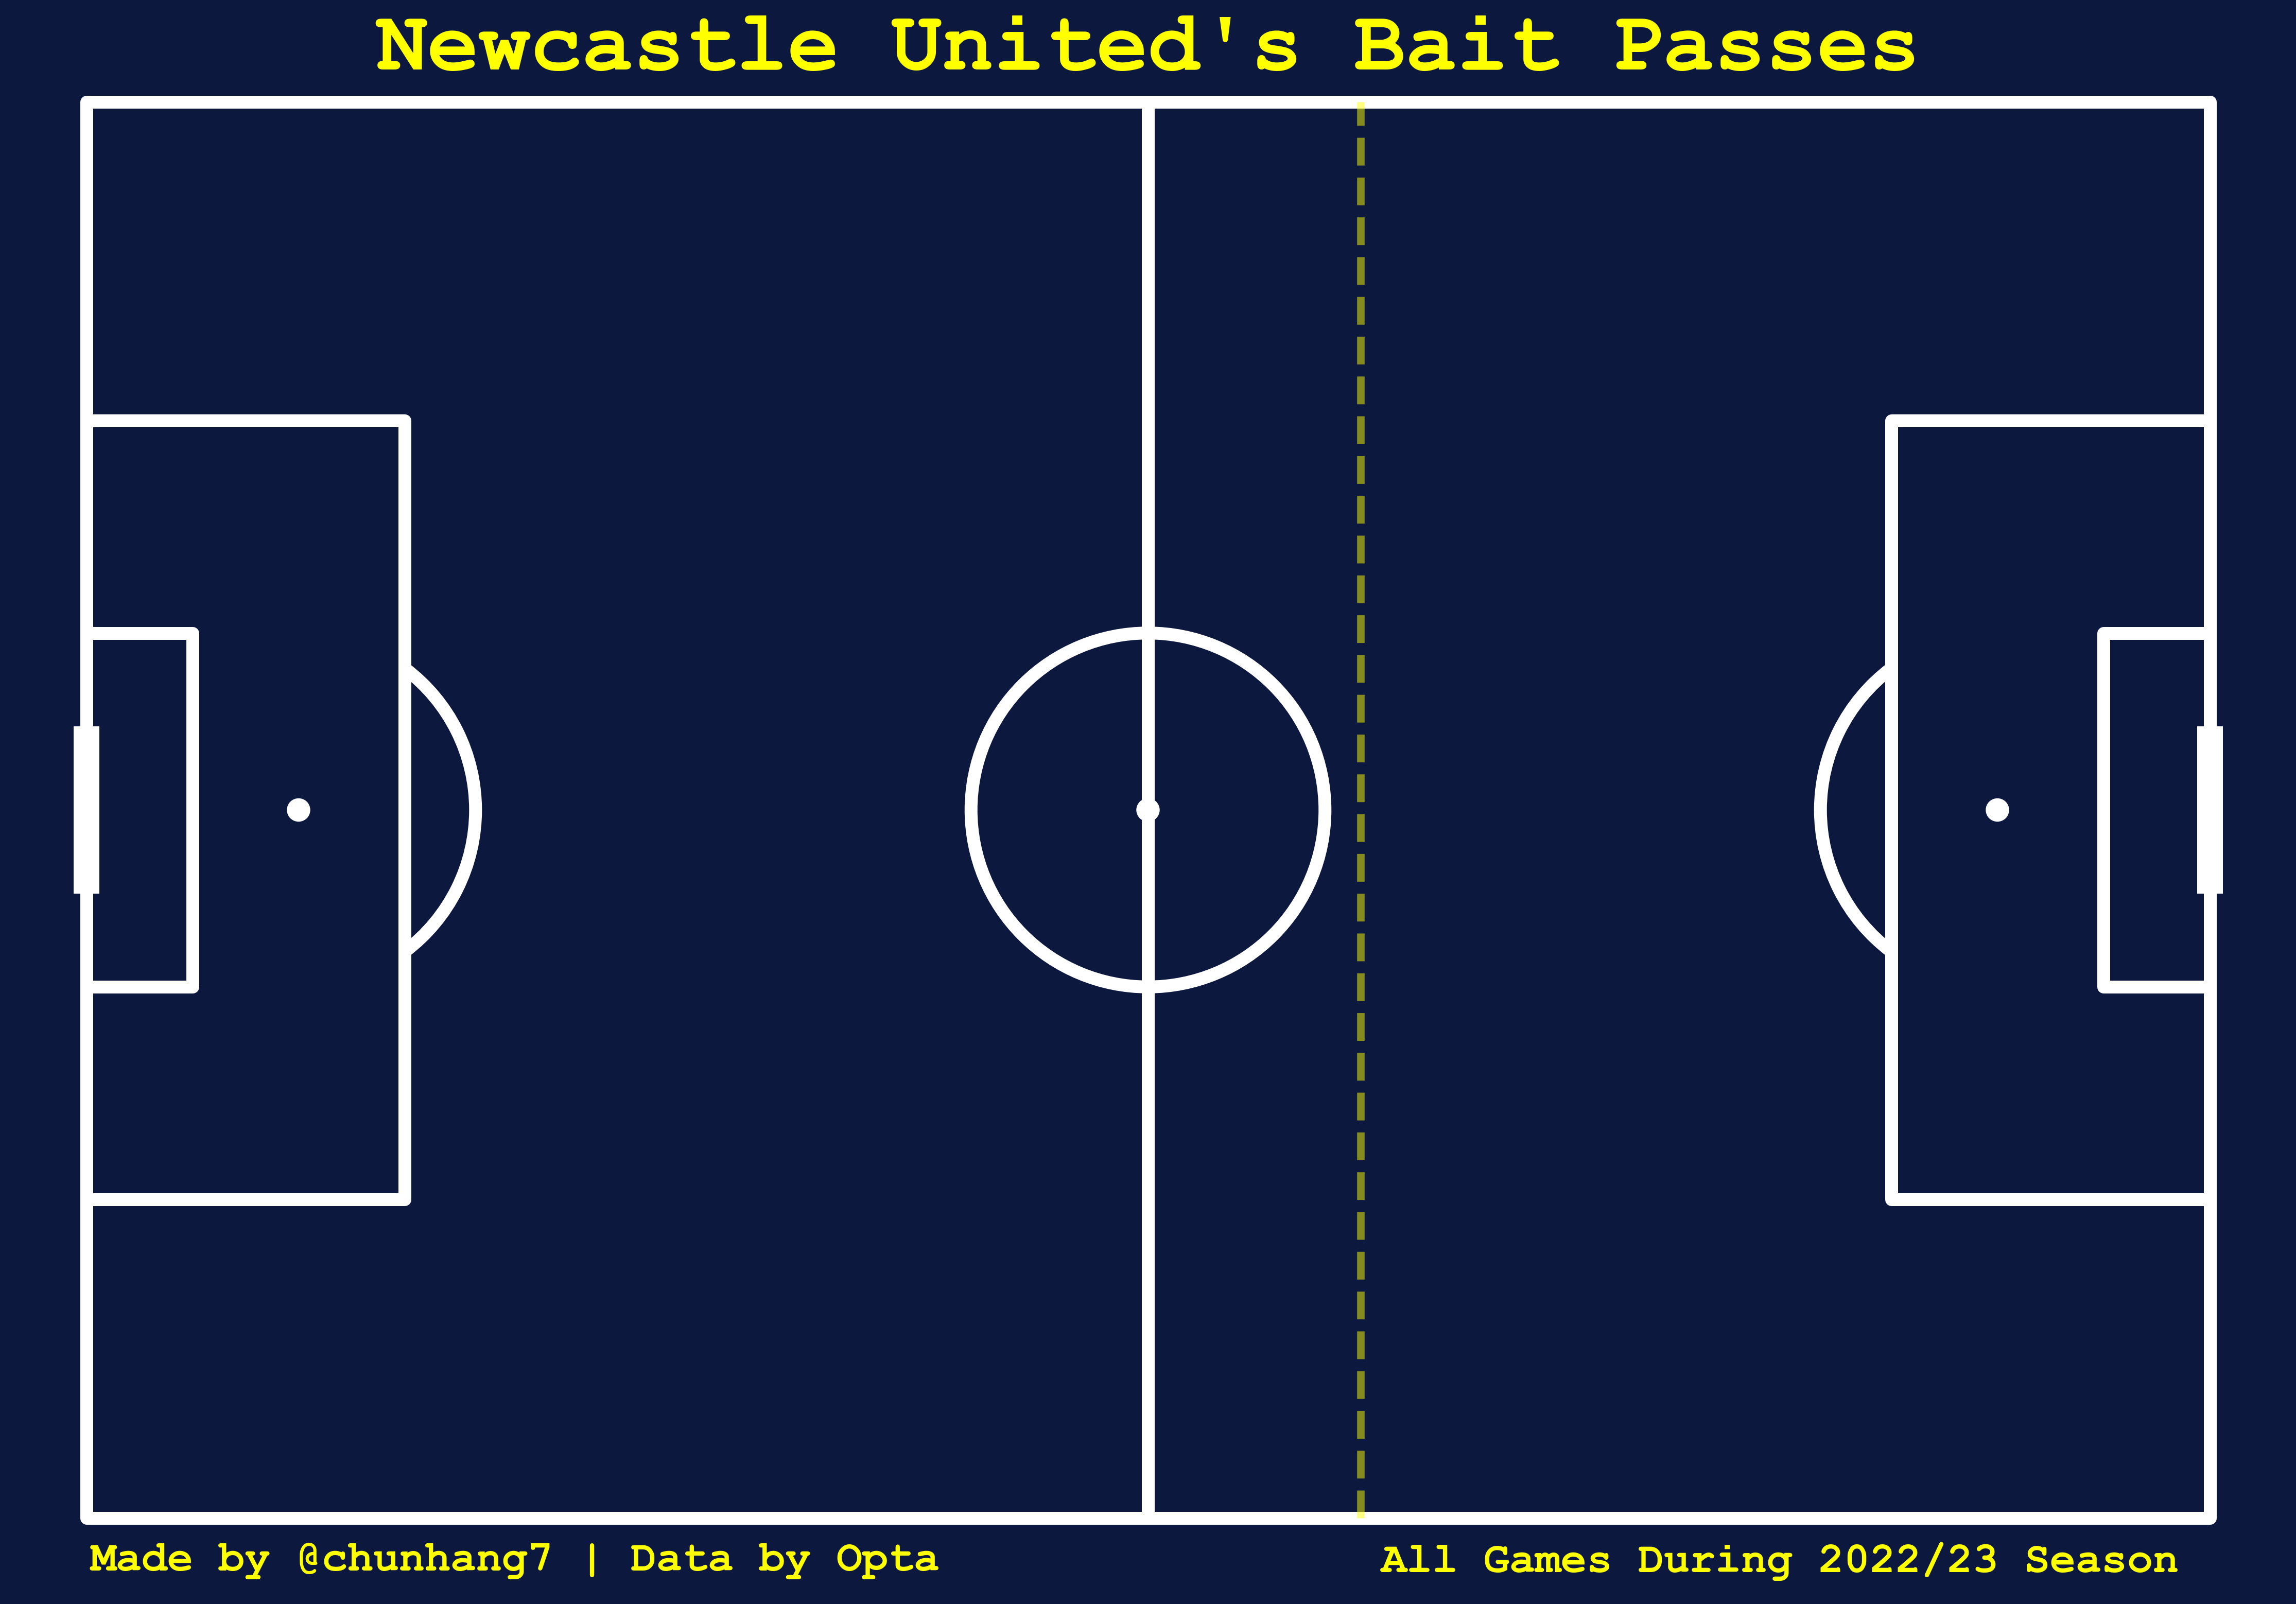

In [18]:
#dpi
mpl.rcParams['figure.dpi'] = 300

#Make the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='#0d183f', line_color='white',linewidth=6, spot_scale=0.005)
fig, ax = pitch.draw(figsize=(15, 11), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#0d183f')

#Inverse y-axis
plt.gca().invert_yaxis()

#Draw line
ax.plot([72,72], [0, 80], c='yellow', lw=3.5,ls='--', alpha = 0.5)

#plot passes made
pitch.scatter(df1['x'], df1['y'],edgecolors= "#aacfec", c="red", s = 2000, 
              zorder=3, ax=ax, marker = 'H', linewidths=4)

pitch.lines(df1.x, df1.y, df1.endX, df1.endY, comet=True, 
            ax=ax, linewidth=15, capstyle='round', zorder=2, color ='crimson')

#Kit Numbers on Nodes
for index, row in df1.iterrows():
    pitch.annotate(row.Num, xy=(row.x+0.05,row.y-0.15), c='w', va='center', ha='center', 
                   size=20, fontweight='bold', fontfamily="Courier New",ax=ax,zorder=6)

#Title & Annotations
fig.suptitle(team + "'s Bait Passes", fontsize=40, color='yellow', zorder=5,
            fontfamily = "Courier New", fontweight = "bold",y=0.94)
    
#Annotations
fig.text(0.41, 0.03, 'Made by @chunhang7 | Data by Opta', fontsize=20, color='yellow', fontweight = 'bold', 
         fontfamily = 'Courier New',ha='right', va='center')

fig.text(0.945, 0.03,'All Games During 2022/23 Season', fontsize=20, color='yellow', fontweight = 'bold', 
         fontfamily = 'Courier New',ha='right', va='center')

"""#Annotations
fig.text(0.51, 0.15, 'Bait Passes: Completed Passes that leads\nto dispossession within 4 seconds\nof Recipient receiving the ball,\nin the defending 60% of the pitch', fontsize=20, color='yellow', fontweight = 'bold', 
         fontfamily = 'Courier New', va='center')
"""
plt.show()